In [44]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [45]:
import numpy as np
import pandas as pd

In [46]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [67]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, Column, Integer, String, Float


In [48]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [50]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [51]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [52]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [89]:
# Create our session (link) from Python to the DB
session = Session(engine)



engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()
# engine.execute('SELECT * FROM station LIMIT 5').fetchall()


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [59]:
inspector = inspect(engine)
    
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [58]:
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


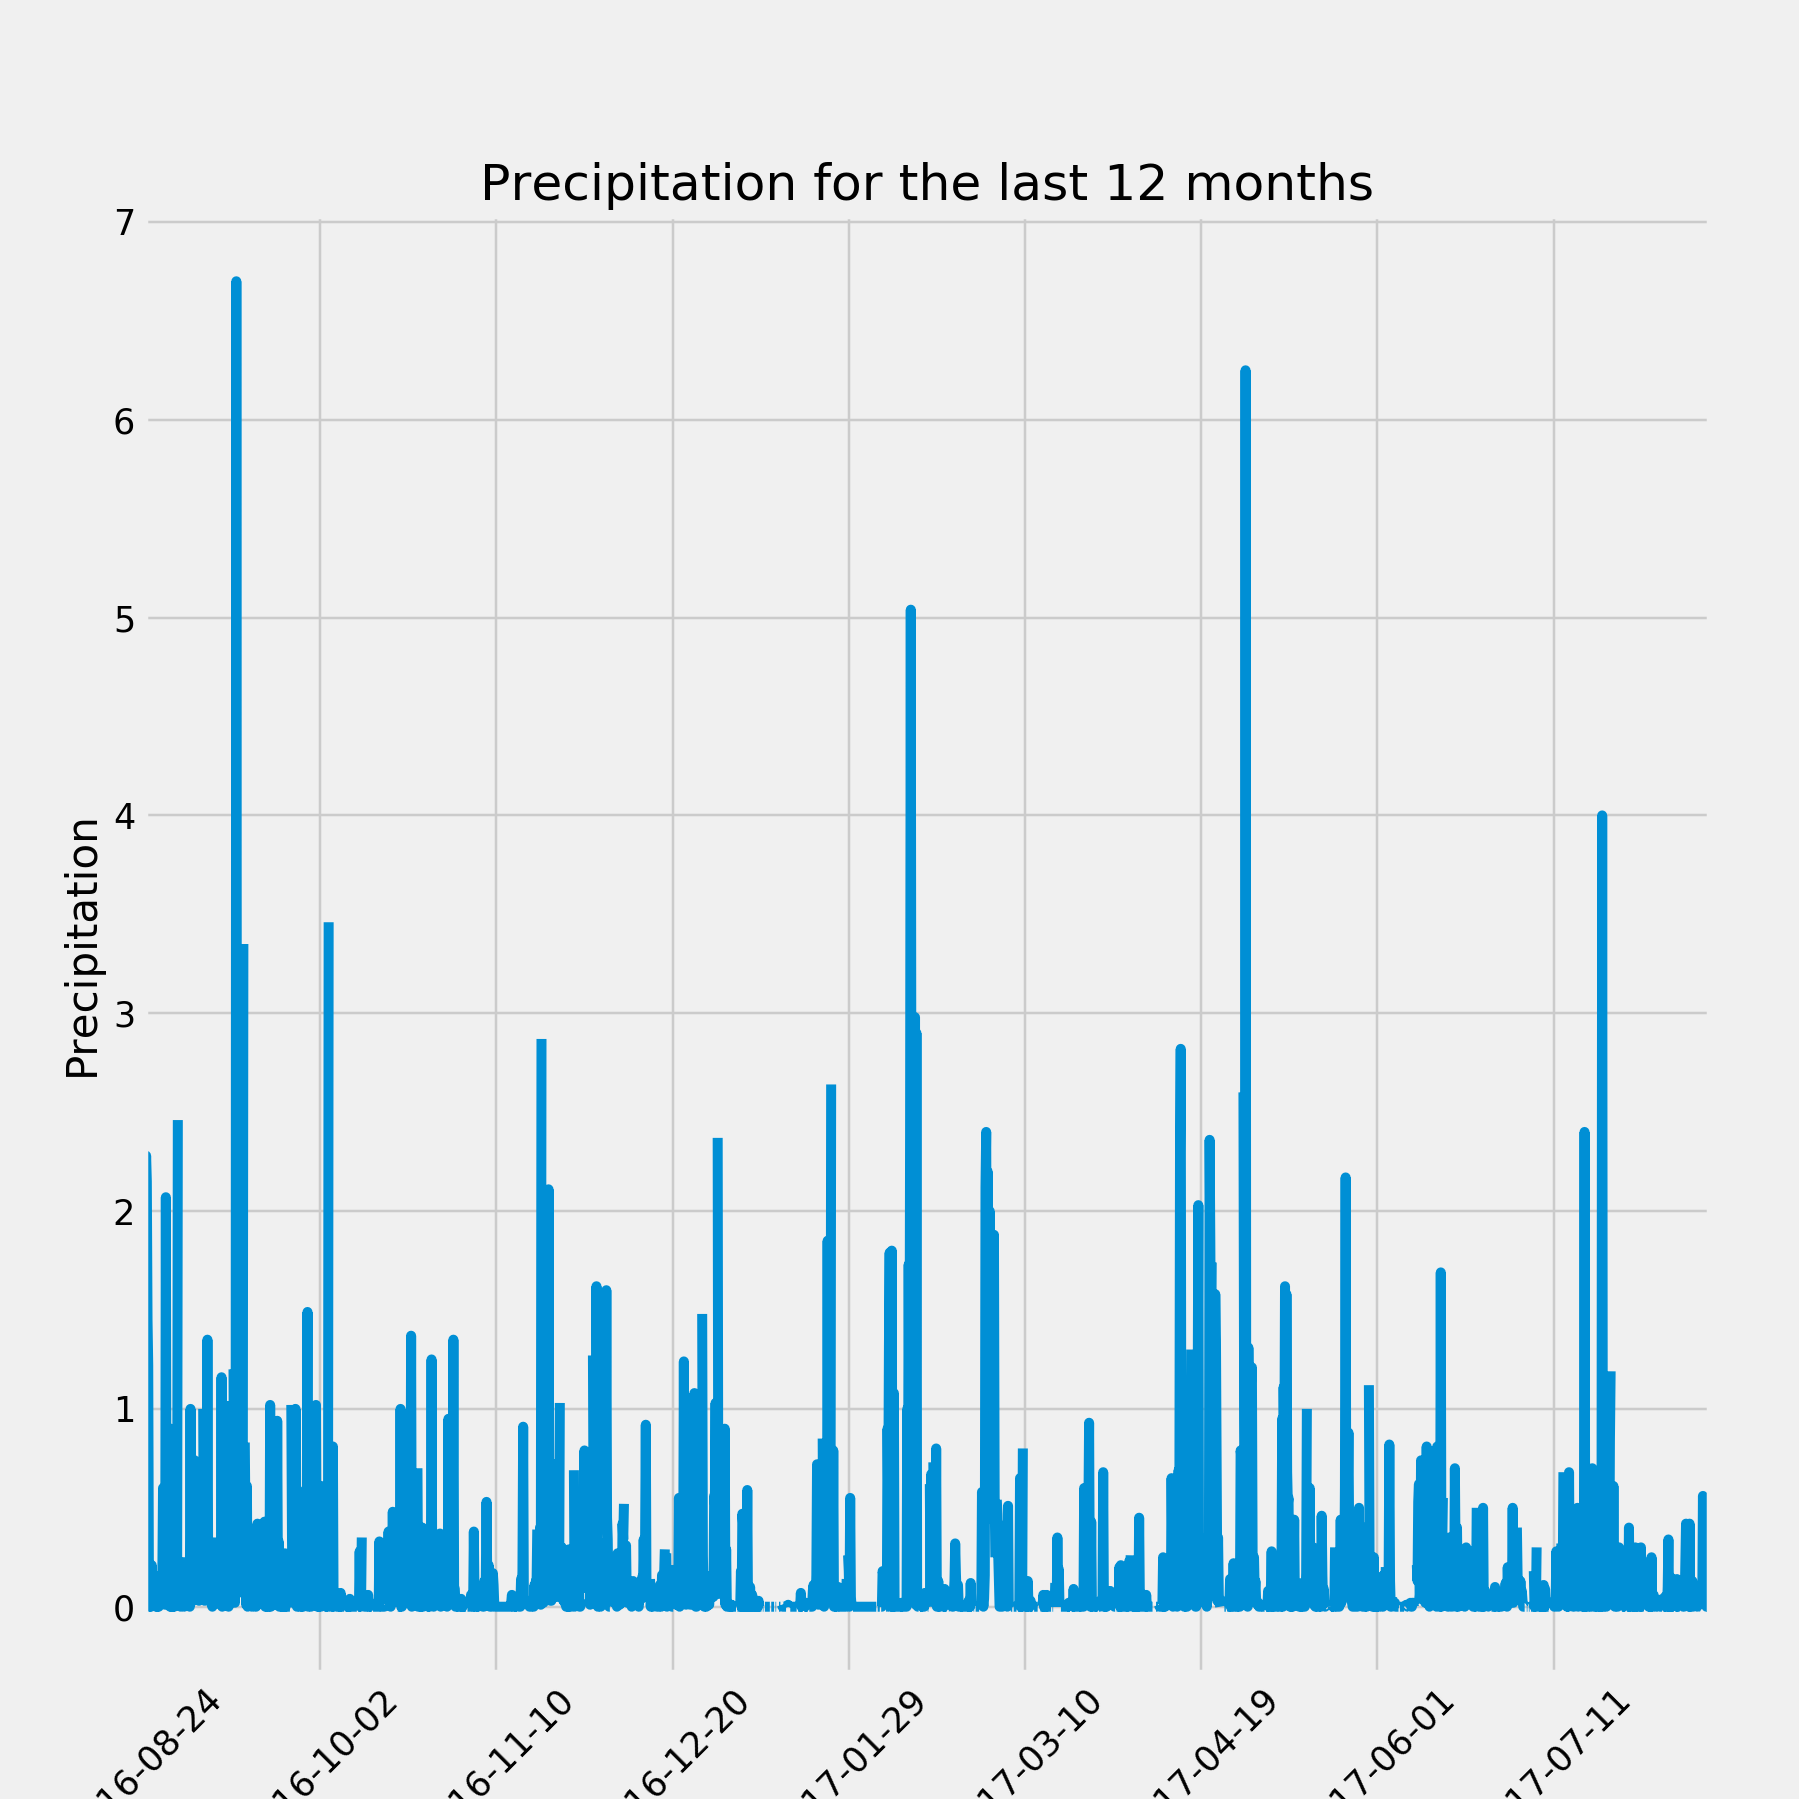

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
# Perform a query to retrieve the data and precipitation scores

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

YearStart = dt.datetime(2016,8,23) 
YearEnd = dt.datetime(2017,8,24)

prcpresults = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > YearStart).filter(Measurement.date < YearEnd).all()

Oneyear_dates = []
Oneyear_prcp = []

for r in prcpresults:
    Oneyear_dates.append(r[0])

for r in prcpresults:
    Oneyear_prcp.append(r[1])
    
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcpresults_DF = pd.DataFrame({'Date':Oneyear_dates, 'Percipitation': Oneyear_prcp})
prcpresults_DF = prcpresults_DF.sort_values(by='Date', ascending=True )
prcpresults_DF = prcpresults_DF.set_index('Date')

# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize=(10,10))
prcpresults_DF.plot(ax=ax,legend=False)

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title("Precipitation for the last 12 months")
ax.set_ylabel("Precipitation")
ax.set_xlabel("date")
plt.xticks(rotation=45)

plt.savefig("Outputs/prcp_last_12_months.png")
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcpresults_DF.describe()


,Percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# How many stations are available in this dataset?
engine.execute('SELECT count(*) FROM station').fetchall()


[(9,)]

In [93]:
# What are the most active stations?
# List the stations and the counts in descending order.

Active = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).statement

dfActive = pd.read_sql_query(Active, session.bind)

dfActive

Station USC00519281,WAIHEE 837.5, HI US has the highest number of observations at 2772.


,station,name,count_1
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [94]:
#Most Active Stations Number
stationactive = dfActive["station"][0]
#Most Active Stations Name
nameactive = dfActive['name'][0]
#highest number of observation
countactive = dfActive['count_1'][0]

print("Station {},{} has the highest number of observations at {}.".format(stationactive,nameactive,countactive))

Station USC00519281,WAIHEE 837.5, HI US has the highest number of observations at 2772.


In [105]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

Active2 = session.query(Measurement.station, Station.name, func.count(Measurement.station), Measurement.tobs).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).statement

dfActive2 = pd.read_sql_query(Active2, session.bind)

minactive = dfActive2['tobs'].min()
maxactive = dfActive2['tobs'].max()
averageactive = dfActive2['tobs'].mean()

70.0

In [106]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
Temp = session.query(Measurement.tobs).\
    filter(Measurement.date > YearBeg).filter(Measurement.date < YearEnd).\
    filter(Measurement.station == stationactive).statement

TempData = pd.read_sql_query(Temp, session.bind)
TempData.head()


,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


<IPython.core.display.Javascript object>


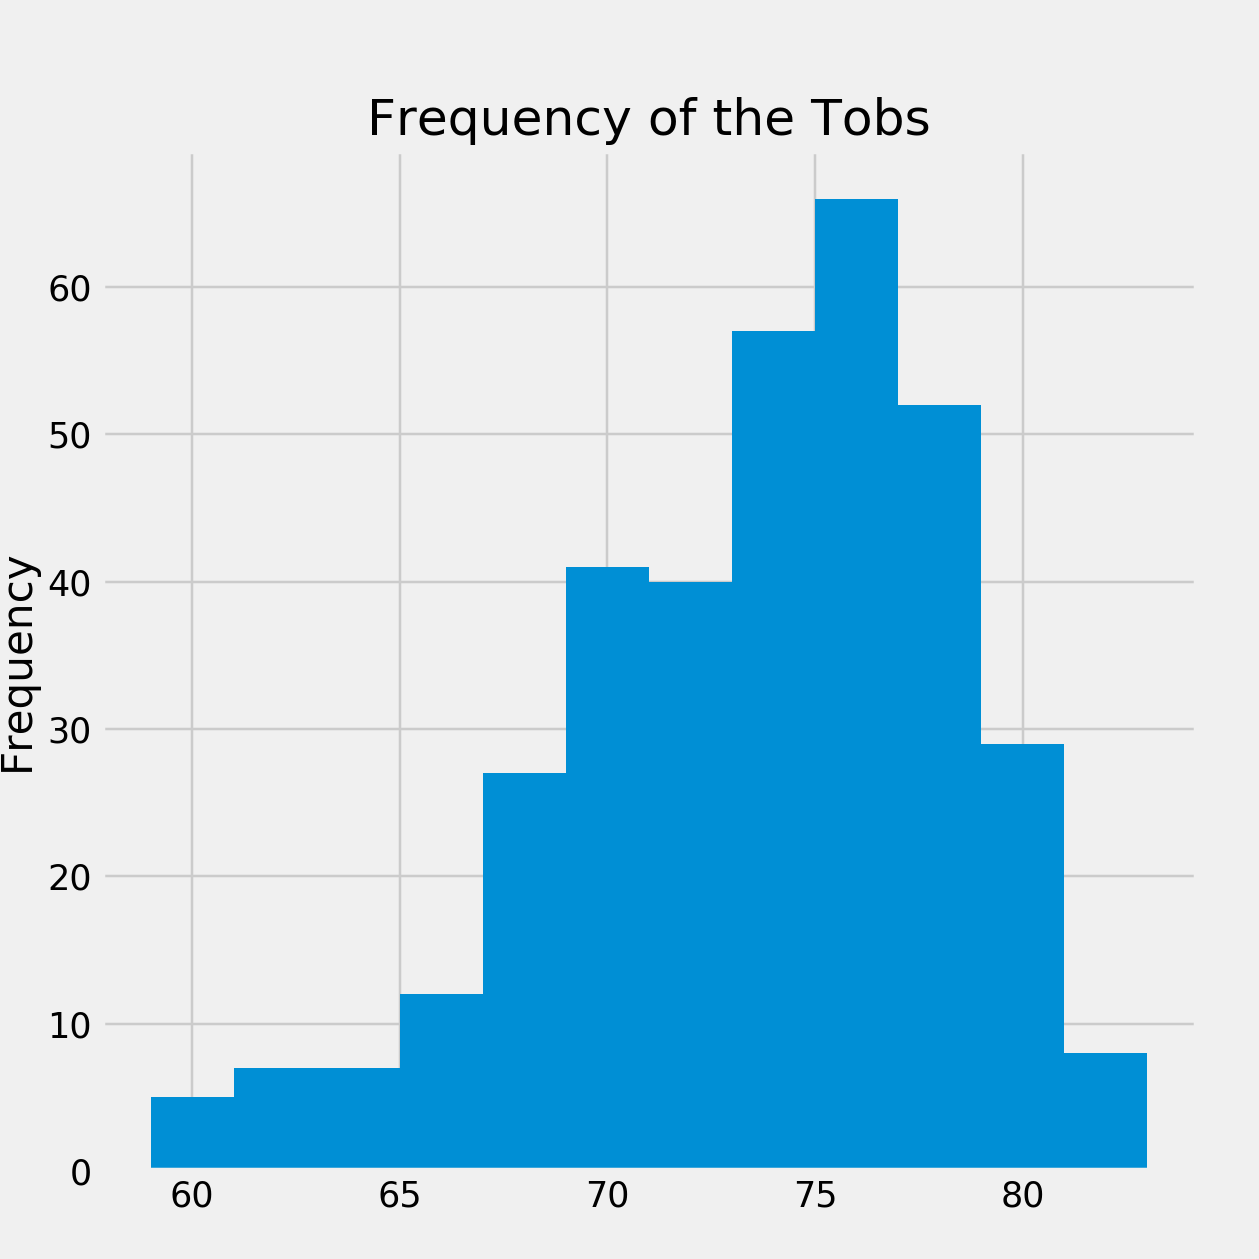

In [121]:
#plot the results as a histogram

ax = TempData.plot(kind="hist",bins=12,figsize=(7,7),legend=False)

ax.set_title("Frequency of the Tobs")
ax.set_ylabel("Tob")
ax.set_ylabel("Frequency")

plt.savefig("Outputs/frequency_of_TOBs.png")
plt.show()